In [1]:
import pandas as pd

import numpy as np

import seaborn as sns

from matplotlib import pyplot as plt

In [2]:
# import dataset
df=pd.read_excel("C:/Users/avignjevic/OneDrive - TeleSign Corporation/Desktop/Practice/Online Retail.xlsx")

## Data Cleaning

In [3]:
# Let's first look at the columns that are in the dataset
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


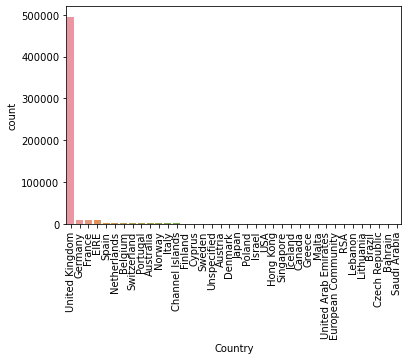

In [4]:
# Eliminate unnecessary columns

# Stock Code, Description (Product) are not neccessary for further analysis . The goal is not to segment customers
# based on geolocation either, so country will be eliminated from further analysis.
#Also UK is disproportionately represented in the dataset

country_count=df["Country"].value_counts().reset_index(name="count")

country_count.rename(columns={"index":"Country"},inplace=True)

p=sns.barplot(data=country_count,x="Country",y="count")

p.tick_params(axis='x', rotation=90);

In [5]:
# Filter to include only relevant columns

df1=df[["InvoiceNo","Quantity","InvoiceDate","UnitPrice","CustomerID"]]

In [6]:
# Let's check for NaN values
df1.isna().sum()

InvoiceNo           0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
dtype: int64

In [7]:
# Without CustomerID we can't calculate recency, frequency and monetary features, therefore these rows will be dropped

df1=df1.dropna()

In [8]:
# Let's take a glance at datatypes
df1.dtypes

InvoiceNo              object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
dtype: object

In [9]:
# CustomerID should be converted to object

df1["CustomerID"]=df1["CustomerID"].astype(str)

In [10]:
# Take a glance at describe method

df1.describe()

# From describe we can see that quantity and price have negative values so I filter these out


,Quantity,UnitPrice
count,406829.000000,406829.000000
mean,12.061303,3.460471
std,248.693370,69.315162
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


In [11]:
df1=df1[df1["UnitPrice"]>0]
df1=df1[df1["Quantity"]>0]

## Recency

In [12]:
# I will calculate recency as the difference in days between the maximum date of the dataset and most recent customer's purchase
#First let's extract year,month,day from date and assign that to new column Date
df1["Date"] = df1["InvoiceDate"].dt.strftime('%Y-%m-%d')
df1["Date"]=pd.to_datetime(df1["Date"])

In [13]:
# find max date
max_date=df1["Date"].max()
max_date=pd.to_datetime(max_date)

In [14]:
# calculate recency and save relevant columns
df2=df1.groupby("CustomerID")["Date"].max().reset_index()
df2["MaxDate"]=max_date
df2["Recency"]=df2["MaxDate"]-df2["Date"]
df2["Recency"]=df2["Recency"].dt.days
df2=df2[["CustomerID","Recency"]]

## Frequency

In [15]:
# Frequency will be calculated as the number of unique invoice numbers each customer ID is associated with
df3=df1.groupby("CustomerID")["InvoiceNo"].nunique().reset_index()
df3.rename(columns={"InvoiceNo":"Frequency"},inplace=True)

## Monetary

In [16]:
# Monetary is the money spent by each customer
df1["Monetary"]=df1["UnitPrice"]*df1["Quantity"]
df4=df1.groupby("CustomerID")["Monetary"].sum().reset_index()

## RFM Table

In [17]:
# Finally combine df2,df3,df4 to get RFM table
df_rfm=pd.merge(df2,df3,on="CustomerID")

In [18]:
df_rfm=pd.merge(df_rfm,df4,on="CustomerID")

#### Divide recency,monetary, frequency into quantlies of similar size

In [19]:
# Find quantiles for each variable
df_rfm["Recency"].quantile([0.34,0.67])

0.34    25.0
0.67    92.0
Name: Recency, dtype: float64

In [20]:
df_rfm["Frequency"].quantile([0.34,0.67])

0.34    1.0
0.67    4.0
Name: Frequency, dtype: float64

In [21]:
df_rfm["Monetary"].quantile([0.34,0.67])

0.34     397.3248
0.67    1215.5890
Name: Monetary, dtype: float64

In [22]:
# Divide data based on quantiles
df_rfm["r_quartile"]=np.where(df_rfm["Recency"]<=25,3,np.where(df_rfm["Recency"]<=92,2,1))
df_rfm["f_quartile"]=np.where(df_rfm["Frequency"]<=1,1,np.where(df_rfm["Frequency"]<=4,2,3))
df_rfm["m_quartile"]=np.where(df_rfm["Monetary"]<=397,1,np.where(df_rfm["Monetary"]<=1215,2,3))

In [23]:
# Combine r_quartile, f_quartile and m_quartile to get an overall rfm
df_rfm["rfm_score"]=df_rfm["r_quartile"].astype(str)+df_rfm["f_quartile"].astype(str)+df_rfm["m_quartile"].astype(str)
df_rfm["rfm_score"]=df_rfm["rfm_score"].astype(int)

In [24]:
df_rfm

,CustomerID,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile,rfm_score
0,12346.0,325,1,77183.60,1,1,3,113
1,12347.0,2,7,4310.00,3,3,3,333
2,12348.0,75,4,1797.24,2,2,3,223
3,12349.0,18,1,1757.55,3,1,3,313
4,12350.0,310,1,334.40,1,1,1,111
...,...,...,...,...,...,...,...,...
4333,18280.0,277,1,180.60,1,1,1,111
4334,18281.0,180,1,80.82,1,1,1,111
4335,18282.0,7,2,178.05,3,2,1,321
4336,18283.0,3,16,2094.88,3,3,3,333


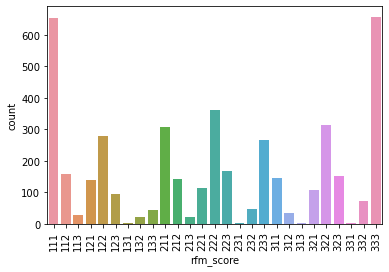

In [25]:
rfm=df_rfm["rfm_score"].value_counts().reset_index()
rfm.rename(columns={"index":"rfm_score",
                      "rfm_score":"count"},inplace=True)
p=sns.barplot(data=rfm,x="rfm_score",y="count")

p.tick_params(axis='x', rotation=90);

In [26]:
df_rfm["Category"]="Other"
df_rfm["Category"]=np.where((df_rfm["rfm_score"]==333) | (df_rfm["rfm_score"]==233),"Champions",df_rfm["Category"])
df_rfm["Category"]=np.where((df_rfm["rfm_score"]==332) | (df_rfm["rfm_score"]==331),"Loyalists",df_rfm["Category"])
df_rfm["Category"]=np.where((df_rfm["rfm_score"]==323) | (df_rfm["rfm_score"]==322),"Potential Loyalists",df_rfm["Category"])
df_rfm["Category"]=np.where((df_rfm["rfm_score"]==312) | (df_rfm["rfm_score"]==311) | (df_rfm["rfm_score"]==313) ,"New Customers",df_rfm["Category"])
df_rfm["Category"]=np.where((df_rfm["rfm_score"]==122) | (df_rfm["rfm_score"]==123) | (df_rfm["rfm_score"]==132) | (df_rfm["rfm_score"]==133) ,"At Risk Customers",df_rfm["Category"])
df_rfm["Category"]=np.where((df_rfm["rfm_score"]==112) | (df_rfm["rfm_score"]==111) | (df_rfm["rfm_score"]==113),"Hibernating",df_rfm["Category"])
df_rfm["Category"]=np.where((df_rfm["rfm_score"]==222) | (df_rfm["rfm_score"]==221),"Promising",df_rfm["Category"])

In [27]:
category=df_rfm["Category"].value_counts(normalize=True).round(2).reset_index()
category.rename(columns=({"index":"Category"}),inplace=True)
category

,Category,Category
0,Other,0.22
1,Champions,0.21
2,Hibernating,0.19
3,Promising,0.11
4,Potential Loyalists,0.11
5,At Risk Customers,0.10
6,New Customers,0.04
7,Loyalists,0.02


### Champions are customer who buy often, have bought recently and are heavy spenders. This category of customers should be rewarded.

### Potential Loyalists are recent customers with average frequency and who spent a good amount. These customers should be offered loyalty programs or membership, or should be recommended related products to help them become Loyalists.

### New Customers are those who have bought recently but are not frequent shoppers. These customers should be offered special offers to increase their visits.

### At Risk Customers are those who used to buy frequently but have not been seen for a while. They should be targeted with reactivation campaigns or offered renewals.

### Promising customers are one step below Potential Loyalists. These customers are average in terms of frequency and recency. They should be sent promotions to increase their recency and frequency.

### Hibernating are those customers who did not buy recently, were not frequent and have not spent a good amount. There is probably no reason to target these customers with any campaigns.

## Reference

## https://clevertap.com/blog/rfm-analysis/

